In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [64]:
camel_data = pd.read_csv('data/camel_data_after2010Q3.csv', index_col = 0)

In [65]:
len(camel_data.index)

7020

In [66]:
camel_set = camel_data.dropna()

In [67]:
len(camel_set)

7014

In [53]:
len(camel_set.loc[camel_set.Target==1])

137

In [54]:
camel_set.describe()

,Target,EQTA,EQTL,LLRTA,LLRGL,OEXTA,INCEMP,ROA,ROE,TDTL,TDTA,TATA
count,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000,7014.000000
mean,0.019532,0.107608,8.018273,0.012324,0.021935,0.024038,33.658510,0.002014,-0.234345,44.793773,0.836190,0.176563
std,0.138396,0.047022,573.838696,0.009367,0.160957,0.030910,1156.779875,0.015034,11.402860,3149.023923,0.077665,0.142330
min,0.000000,-0.160659,-0.195857,0.000000,0.000000,-0.012004,-3639.467742,-0.295750,-887.458333,0.000000,0.000000,0.000000
25%,0.000000,0.087488,0.125309,0.007217,0.012123,0.018271,3.084559,0.000903,0.009427,1.126866,0.805744,0.066565
50%,0.000000,0.101018,0.156656,0.010043,0.015918,0.022050,18.162698,0.004831,0.045176,1.274030,0.850241,0.148197
75%,0.000000,0.120994,0.211900,0.014292,0.022126,0.026404,34.348039,0.008415,0.078186,1.527378,0.883622,0.258628
max,1.000000,0.953921,47829.250000,0.161906,12.250000,2.164806,73600.000000,0.173673,21.963100,260238.500000,1.151905,0.868327


In [55]:
y = camel_set['Target']
X = camel_set.drop(['Target', 'AsOfDate'], axis=1)

In [68]:
# Standardizing the features
X_pca_std = StandardScaler().fit_transform(X)

In [102]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X_pca_std)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['PC_1', 'PC_2', 'PC_3', 'PC_4'])
pca.explained_variance_ratio_

array([0.26089305, 0.19384157, 0.12502192, 0.09285672])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [11]:
log_reg = LogisticRegression(random_state=1)
log_reg.fit(X_train_std,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
log_reg.coef_

array([[-3.30631369e+00,  2.60394438e-02,  1.21834391e-01,
         2.35215170e-02, -1.40380149e+00,  3.13836102e-02,
        -1.13753938e-01, -1.21359512e-02, -1.84731123e-03,
         3.71548636e-02, -3.81625762e-01]])

In [13]:
log_reg.score(X_train_std, y_train)

0.987702726786669

In [14]:
log_reg.score(X_test_std, y_test)

0.9935851746258019

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


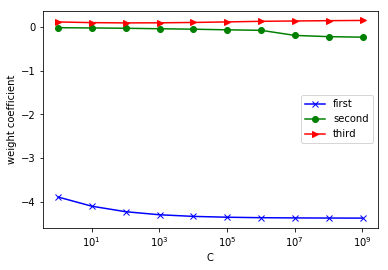

In [20]:
weights, params = [], []
for c in np.arange(0.01,10): 
    lr = LogisticRegression(C=2**c, random_state=0, solver='lbfgs')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

# Decision region drawing
import matplotlib.pyplot as plt

plt.plot(params, weights[:, 0], color='blue', marker='x', label='first')
plt.plot(params, weights[:, 1], color='green',  marker='o', label='second')
plt.plot(params, weights[:, 2], color='r',  marker='>', label='third')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='right')
plt.xscale('log')
plt.show()

## Ploting learning curves

In [24]:
def plot_learning_curves(model, X_train_std, X_test_std, y_train, y_test):
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    train_errors, val_errors = [], []
    for m in range(10, len(X_train_std)):
        model.fit(X_train_std[:m], y_train[:m])
        y_train_predict = model.predict(X_train_std[:m])
        y_val_predict = model.predict(X_test_std)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='test')

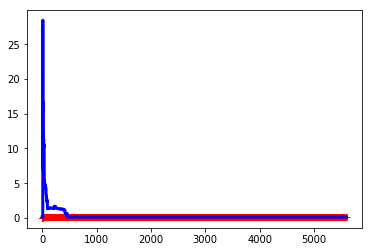

In [28]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X_train_std, X_test_std, y_train, y_test)

In [29]:
sgd_clf = SGDClassifier(random_state=1)
sgd_clf.fit(X_train_std, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
sgd_clf.score(X_train_std, y_train)

0.988950276243094

In [31]:
sgd_clf.score(X_test_std, y_test)

0.9900213827512473

In [32]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_std, y_train, cv=3, scoring='accuracy')

array([0.98717263, 0.98717263, 0.99036918])

In [33]:
cross_val_score(log_reg, X_train_std, y_train, cv=3, scoring='accuracy')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.98663816, 0.98450027, 0.98983414])

In [34]:
# Accuracy score is generally not a good performance measure for classifiers, especially when you are dealing with 
# skewed datasets (when some classes are much more frequent than others) -- check with confusing matrix below:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
sgd_y_train_pred = cross_val_predict(sgd_clf, X_train_std, y_train, cv=3)
confusion_matrix(y_train, sgd_y_train_pred)

array([[5467,   34],
       [  32,   78]])

In [35]:
# Same terrible results for logit regression:
log_y_train_pred = cross_val_predict(log_reg, X_train_std, y_train, cv=3)
confusion_matrix(y_train, log_y_train_pred)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[5477,   24],
       [  49,   61]])

## To get the value of precision we divide the total number of correctly classified positive examples by the total number of predicted positive examples. High Precision indicates an example labeled as positive is indeed positive (small number of FP).

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train, sgd_y_train_pred) #SGD precision

0.6964285714285714

In [37]:
precision_score(y_train, log_y_train_pred) #Logit precision

0.7176470588235294

## Recall can be defined as the ratio of the total number of correctly classified positive examples divide to the total number of positive examples. High Recall indicates the class is correctly recognized (small number of FN).

In [38]:
recall_score(y_train, sgd_y_train_pred) #SGD precision

0.7090909090909091

In [39]:
recall_score(y_train, log_y_train_pred) #Logit recall

0.5545454545454546

## High recall, low precision:This means that most of the positive examples are correctly recognized (low FN) but there are a lot of false positives. Low recall, high precision:This shows that we miss a lot of positive examples (high FN) but those we predict as positive are indeed positive (low FP)

In [40]:
f1_score(y_train, log_y_train_pred)

0.6256410256410256

In [41]:
f1_score(y_train, sgd_y_train_pred)

0.7027027027027026

In [ ]:
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
actual = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0] 
predicted = [1, 0, 0, 1, 0, 0, 1, 1, 1, 0] 
results = confusion_matrix(actual, predicted) 
print 'Confusion Matrix :'
print(results) 
print 'Accuracy Score :',accuracy_score(actual, predicted) 
print 'Report : '
print classification_report(actual, predicted) 

In [42]:
# Precision/Recall tradeoff 
from sklearn.metrics import precision_recall_curve

sgd_y_scores = cross_val_predict(sgd_clf, X_train_std, y_train, cv=3, method='decision_function')
sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(y_train, sgd_y_scores)

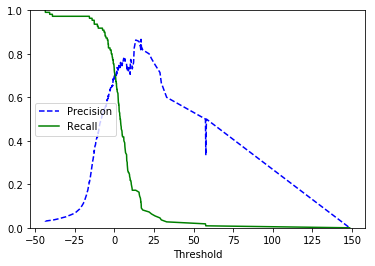

In [43]:
 #Represent Precision and Recall graphically
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[: -1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

plot_precision_recall(sgd_precisions, sgd_recalls, sgd_thresholds)
plt.show()

In [44]:
# Logit needs predict_proba output fist

# log_y_scores = cross_val_predict(log_reg, X_train_std, y_train, cv=3, method='decison_function')
# log_precisions, log_recalls, log_thresholds = precision_recall_curve(y_train, log_y_scores)
# plot_precision_recall(log_precisions, log_recalls, log_thresholds)
# plt.show()

In [45]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, sgd_y_scores)

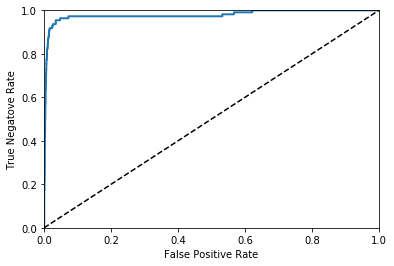

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Negatove Rate')
plot_roc_curve(fpr, tpr)